<a href="https://colab.research.google.com/github/Foysal061/Api-testing/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
#pip install openmeteo-requests requests-cache retry-requests numpy pandas tensorflow scikit-learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import openmeteo_requests
import requests_cache
from retry_requests import retry
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
print("Libraries imported successfully!")

Libraries imported successfully!


In [72]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

def load_ed_data(filepath, separator=';'):
    """Load ED data from CSV"""
    print("\n[1/8] Loading ED data...")
    df = pd.read_csv(filepath, sep=separator)
    df.columns = ['arrival', 'departure', 'first_doctor_response', 'first_triage']
    print(f"Loaded {len(df)} records")
    print(df.head())
    return df

df = load_ed_data("/content/drive/MyDrive/Colab Notebooks/VestfoldTriageReport.csv")

def parse_datetime_columns(df):
    print("Parsing datetime fields.")

    # Convert to datetime, invalid parsing becomes NaT
    df['arrival'] = pd.to_datetime(df['arrival'], format='%d.%m.%Y %H:%M', errors='coerce')
    df['departure'] = pd.to_datetime(df['departure'], format='%d.%m.%Y %H:%M', errors='coerce')

    # Drop rows where parsing failed
    df = df.dropna(subset=['arrival', 'departure'])

    df = df.sort_values('arrival')

    local_zone = 'Europe/Oslo'
    df['arrival'] = df['arrival'].dt.tz_localize(local_zone).dt.tz_convert('UTC').dt.tz_localize(None)
    df['departure'] = df['departure'].dt.tz_localize(local_zone).dt.tz_convert('UTC').dt.tz_localize(None)


    df['duration_minutes'] = (df['departure'] - df['arrival']).dt.total_seconds() / 60

    print(f"Parsed datetimes in UTC, {len(df)} records remaining")
    print(df.head())
    return df

df = parse_datetime_columns(df)

def aggregate_to_hourly(df):
    """Aggregate data to hourly intervals"""
    print("\n[3/8] Aggregating to hourly intervals...")
    df['arrival_hour'] = df['arrival'].dt.floor('H')

    # Aggregate only essential metrics
    hourly_df = df.groupby('arrival_hour').agg({
        'arrival': 'count',
        'duration_minutes': ['mean', 'std']
    })

    hourly_df.columns = ['arrival_count', 'duration_mean', 'duration_std']
    hourly_df = hourly_df.reset_index()
    hourly_df[['duration_mean', 'duration_std']] = hourly_df[['duration_mean', 'duration_std']].fillna(0)

    print(f"Aggregated to {len(hourly_df)} hourly records")
    return hourly_df

df = aggregate_to_hourly(df)
print(df.head())


[1/8] Loading ED data...
Loaded 35674 records
            arrival         departure first_doctor_response   first_triage
0  01.10.2023 13:46  06.10.2023 18:10            LessUrgent  Resuscitation
1  01.10.2023 14:20  20.10.2023 11:37            LessUrgent     LessUrgent
2  01.10.2023 13:59  03.10.2023 12:04                   NaN  Resuscitation
3  01.10.2023 14:40  01.10.2023 17:30            LessUrgent     LessUrgent
4  01.10.2023 13:50  01.10.2023 20:45             NotUrgent         Urgent
Parsing datetime fields.
Parsed datetimes in UTC, 35674 records remaining
              arrival           departure first_doctor_response  \
0 2023-10-01 11:46:00 2023-10-06 16:10:00            LessUrgent   
4 2023-10-01 11:50:00 2023-10-01 18:45:00             NotUrgent   
7 2023-10-01 11:59:00 2023-10-05 13:05:00                Urgent   
2 2023-10-01 11:59:00 2023-10-03 10:04:00                   NaN   
8 2023-10-01 12:20:00 2023-10-02 12:01:00            LessUrgent   

    first_triage  duration

In [73]:
# =============================================================================
# WEATHER DATA FETCHING
# =============================================================================

def fetch_weather_data(start_date, end_date, is_hourly=False):
    """Fetch weather data from Open-Meteo API (hourly or daily)"""

    data_type = "hourly" if is_hourly else "daily"
    print(f"\n[5/8] Fetching {data_type} weather data...")

    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    # Build parameters based on is_hourly flag
    if is_hourly:
        params = {
            "latitude": 59.2725,
            "longitude": 10.4184,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": [
                "temperature_2m",
                "relative_humidity_2m",
                "precipitation",
                "surface_pressure",
                "wind_speed_10m"
            ]
        }
    else:
        params = {
            "latitude": 59.2725,
            "longitude": 10.4184,
            "start_date": start_date,
            "end_date": end_date,
            "daily": [
                "temperature_2m_mean",
                "temperature_2m_max",
                "temperature_2m_min",
                "precipitation_sum",
                "rain_sum",
                "wind_speed_10m_max",
                "wind_speed_10m_mean"
            ]
        }

    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Build dataframe with essential weather features
    if is_hourly:
      hourly = response.Hourly()
      timestamps = pd.date_range(
          start=pd.to_datetime(hourly.Time(), unit="s"),
          end=pd.to_datetime(hourly.TimeEnd(), unit="s"),
          freq=pd.Timedelta(seconds=hourly.Interval()),
          inclusive="left"
      )
      hourly_data = {
          "date": timestamps,
          "temperature": hourly.Variables(0).ValuesAsNumpy().astype(float).round(2),
          "humidity": hourly.Variables(1).ValuesAsNumpy().astype(float).round(2),
          "precipitation": hourly.Variables(2).ValuesAsNumpy().astype(float).round(2),
          "pressure": hourly.Variables(3).ValuesAsNumpy().astype(float).round(2),
          "wind_speed": hourly.Variables(4).ValuesAsNumpy().astype(float).round(2)
      }

      weather_df = pd.DataFrame(hourly_data)
    else:
      # Process daily data
      daily = response.Daily()
      timestamps = pd.date_range(
          start=pd.to_datetime(daily.Time(), unit="s"),
          end=pd.to_datetime(daily.TimeEnd(), unit="s"),
          freq=pd.Timedelta(seconds=daily.Interval()),
          inclusive="left"
      )

      # Build dataframe with daily weather features
      daily_data = {
          "date": timestamps,
          "temp_mean": daily.Variables(0).ValuesAsNumpy().astype(float).round(2),
          "temp_max": daily.Variables(1).ValuesAsNumpy().astype(float).round(2),
          "temp_min": daily.Variables(2).ValuesAsNumpy().astype(float).round(2),
          "precipitation": daily.Variables(3).ValuesAsNumpy().astype(float).round(2),
          "rain": daily.Variables(4).ValuesAsNumpy().astype(float).round(2),
          "wind_max": daily.Variables(5).ValuesAsNumpy().astype(float).round(2),
          "wind_mean": daily.Variables(6).ValuesAsNumpy().astype(float).round(2)
      }

      weather_df = pd.DataFrame(daily_data)

    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_localize(None)

    print(f"Created weather dataframe with {len(weather_df)} records")
    return weather_df

weather_df = fetch_weather_data("2023-01-10", "2024-10-26", True)

def merge_weather_data(df, weather_df, is_hourly = False):
    """Merge weather data with ED data"""
    print("\n[6/8] Merging weather data...")
    if is_hourly:
      col_name = 'arrival_hour'
    else:
      col_name = 'arrival_date'

    print(col_name)
    df[col_name] = pd.to_datetime(df[col_name], errors='coerce')
    weather_df['date'] = pd.to_datetime(weather_df['date'], errors='coerce')

    df = df.dropna(subset=[col_name])

    if is_hourly:
      merged_df = pd.merge_asof(
        df.sort_values("arrival_hour"),
        weather_df.sort_values("date"),
        left_on="arrival_hour",
        right_on="date",
        direction="nearest"
      )
    else:
      merged_df = pd.merge(
            df,
            weather_df,
            left_on="arrival_date",
            right_on="date",
            how="left"
        )

    # Drop the duplicate date column
    merged_df = merged_df.drop(columns=['date'], errors='ignore')

    print(f"Merged data: {len(merged_df)} records with {len(merged_df.columns)} total columns")
    print(merged_df.head())
    return merged_df

df = merge_weather_data(df, weather_df, True)


[5/8] Fetching hourly weather data...
Created weather dataframe with 15744 records

[6/8] Merging weather data...
arrival_hour
Merged data: 8284 records with 9 total columns
         arrival_hour  arrival_count  duration_mean  duration_std  \
0 2023-10-01 11:00:00              4    4117.500000   3144.084233   
1 2023-10-01 12:00:00              6    6230.833333  10460.660083   
2 2023-10-01 13:00:00              6    3253.166667   4289.686768   
3 2023-10-01 14:00:00              3     671.000000    731.448563   
4 2023-10-01 15:00:00              6    6644.500000   6639.924962   

   temperature  humidity  precipitation  pressure  wind_speed  
0        15.90     65.10            0.0   1012.48        9.34  
1        14.90     58.57            0.0   1012.97        3.67  
2        15.05     59.01            0.0   1012.87        6.29  
3        14.50     63.26            0.0   1012.47        9.11  
4        13.65     66.62            0.0   1011.96       10.46  


In [74]:
# =============================================================================
# INFECTION DATA
# =============================================================================

def load_merge_infection_data(df, is_hourly=False):

  if is_hourly:
    col_name = 'arrival_hour'
  else:
    col_name = 'arrival_date'

  # Load the monthly infection data
  monthly_df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Infeksjonsdata.xlsx", header=0)
  monthly_df = monthly_df.rename(columns=lambda x: f'{x}_Infected_Patient_Monthly_Count' if x not in ['Month', 'Total_Infected_Patient_Monthly'] else x)

  df['year_month'] = df[col_name].dt.to_period('M')
  monthly_df['year_month'] = monthly_df['Month'].dt.to_period('M')

  df_merged = df.merge(
      monthly_df.drop('Month', axis=1),  # drop the original date column
      on='year_month',
      how='left'
  )

  df_merged = df_merged.drop('year_month', axis=1)

  print(df_merged.head())
  return df_merged

df = load_merge_infection_data(df, True)

         arrival_hour  arrival_count  duration_mean  duration_std  \
0 2023-10-01 11:00:00              4    4117.500000   3144.084233   
1 2023-10-01 12:00:00              6    6230.833333  10460.660083   
2 2023-10-01 13:00:00              6    3253.166667   4289.686768   
3 2023-10-01 14:00:00              3     671.000000    731.448563   
4 2023-10-01 15:00:00              6    6644.500000   6639.924962   

   temperature  humidity  precipitation  pressure  wind_speed  \
0        15.90     65.10            0.0   1012.48        9.34   
1        14.90     58.57            0.0   1012.97        3.67   
2        15.05     59.01            0.0   1012.87        6.29   
3        14.50     63.26            0.0   1012.47        9.11   
4        13.65     66.62            0.0   1011.96       10.46   

   Total_Infected_Patient_Monthly  ...  \
0                             616  ...   
1                             616  ...   
2                             616  ...   
3                         

In [75]:
# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

def create_lag_and_temporal_features(df, target_col='arrival_count', lags=[1], fill_method='drop', create_lead=True):
    """
    Create lag features for time series

    Args:
        df: DataFrame with time series data
        target_col: Column to create lags for
        lags: List of lag periods (in hours for hourly data, days for daily)
        fill_method: How to handle NaN from lags - 'drop', 'ffill' (forward fill), or 'zero'
        create_lead: If True, create a lead feature (shift -1) for the target

    Returns:
        DataFrame with lag features added
    """
    print(f"\n[Lag Features] Creating lag features for {target_col}...")

    # Create lag features (past values)
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
        print(f"  Created lag_{lag} (value from {lag} hour(s) ago)")

    # Create lead feature (future value) - this will be our target
    if create_lead:
        df[f'{target_col}_next'] = df[target_col].shift(-1)
        print(f"  Created {target_col}_next (value 1 hour ahead - this is our target y)")

    # Handle NaN values based on fill_method
    initial_rows = len(df)

    if fill_method == 'drop':
        df = df.dropna()
        dropped_rows = initial_rows - len(df)
        print(f"  Dropped {dropped_rows} rows due to NaN in lag/lead features")
    elif fill_method == 'ffill':
        lag_cols = [f'{target_col}_lag_{lag}' for lag in lags]
        if create_lead:
            lag_cols.append(f'{target_col}_next')
        df[lag_cols] = df[lag_cols].fillna(method='ffill')
        print(f"  Forward-filled NaN values in lag features")
    elif fill_method == 'zero':
        lag_cols = [f'{target_col}_lag_{lag}' for lag in lags]
        if create_lead:
            lag_cols.append(f'{target_col}_next')
        df[lag_cols] = df[lag_cols].fillna(0)
        print(f"  Filled NaN values with 0 in lag features")

    return df

def create_temporal_features(df, is_hourly=False):
    """Create comprehensive temporal features"""
    print("\n[4/8] Creating temporal features...")

    if is_hourly:
      col_name = 'arrival_hour'
      # Hour features
      df['hour'] = df[col_name].dt.hour
      df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
      df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    else:
      col_name = 'arrival_date'

    # Basic temporal features
    df['day'] = df[col_name].dt.day
    df['dayofweek'] = df[col_name].dt.dayofweek
    df['week'] = df[col_name].dt.isocalendar().week
    df['month'] = df[col_name].dt.month
    df['year'] = df[col_name].dt.year
    df['day_of_year'] = df[col_name].dt.dayofyear

    # Categorical temporal features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_monday'] = (df['dayofweek'] == 0).astype(int)
    df['is_friday'] = (df['dayofweek'] == 4).astype(int)

    # Cyclical encoding (important for capturing periodic patterns)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    print(f"Created {len([c for c in df.columns if c not in [col_name, 'arrival_count']])} features")
    return df

USE_LAG_FEATURES = True  # Set to False to exclude lag features

if USE_LAG_FEATURES:
    print("\n✓ Creating lag features for next-hour prediction")
    # Selected lags to capture key patterns (max 4 lags):
    # - lag_1: 1 hour ago (immediate past)
    # - lag_24: Same hour yesterday (daily pattern)
    df = create_lag_and_temporal_features(
        df,
        target_col='arrival_count',
        lags=[1,6,12, 24],  # 1h ago, 1 day ago
        fill_method='drop',
        create_lead=True  # Create arrival_count_next as target
    )

    # Now use arrival_count_next as the target
    TARGET_COL = 'arrival_count_next'
    print(f"Using '{TARGET_COL}' as target (next hour's patient count)")
else:
    print("Skipping lag features (model will learn from temporal/weather only)")
    TARGET_COL = 'arrival_count'

print(df.head())


✓ Creating lag features for next-hour prediction

[Lag Features] Creating lag features for arrival_count...
  Created lag_1 (value from 1 hour(s) ago)
  Created lag_6 (value from 6 hour(s) ago)
  Created lag_12 (value from 12 hour(s) ago)
  Created lag_24 (value from 24 hour(s) ago)
  Created arrival_count_next (value 1 hour ahead - this is our target y)
  Dropped 25 rows due to NaN in lag/lead features
Using 'arrival_count_next' as target (next hour's patient count)
          arrival_hour  arrival_count  duration_mean  duration_std  \
24 2023-10-02 13:00:00              9    2295.000000   2062.886146   
25 2023-10-02 14:00:00              5   10287.200000  13239.544883   
26 2023-10-02 15:00:00              2   10683.000000  13498.668453   
27 2023-10-02 16:00:00              6    1230.166667    678.971109   
28 2023-10-02 17:00:00             10    2429.500000   2080.691725   

    temperature  humidity  precipitation  pressure  wind_speed  \
24         16.1     56.31            0.0

In [76]:
# =============================================================================
def prepare_sequences_improved(df, target_col='arrival_count', lookback=24,
                                forecast_horizon=1, exclude_cols=[],
                                feature_scaler_type='robust',
                                target_scaler_type='standard'):
    """
    Improved sequence preparation with better scaling options

    Args:
        df: DataFrame with time series data
        target_col: Target column name
        lookback: Number of past timesteps to use
        forecast_horizon: Number of steps ahead to predict
        exclude_cols: Columns to exclude from features
        feature_scaler_type: 'standard', 'minmax', 'robust', or 'none'
        target_scaler_type: 'standard', 'minmax', 'robust', or 'none'

    Scaling Options:
        - 'standard': StandardScaler - good for normally distributed data
        - 'minmax': MinMaxScaler - scales to [0,1], good for bounded predictions
        - 'robust': RobustScaler - uses median/IQR, robust to outliers
        - 'none': No scaling

    Recommended for ED arrivals (count data):
        - Features: 'robust' (handles outliers in weather/infection data)
        - Target: 'minmax' (patient counts are bounded, non-negative)
    """
    print(f"\n[7/8] Preparing sequences for LSTM (IMPROVED)...")
    print(f"  • Lookback window: {lookback} hours")
    print(f"  • Feature scaler: {feature_scaler_type}")
    print(f"  • Target scaler: {target_scaler_type}")

    feature_cols = [col for col in df.columns if col not in exclude_cols]

    print(f"  • Using {len(feature_cols)} features:")

    # Extract features and target
    features = df[feature_cols].values
    target = df[target_col].values

    # =========================================================================
    # FEATURE SCALING
    # =========================================================================
    if feature_scaler_type == 'standard':
        scaler_X = StandardScaler()
        print("  • Using StandardScaler for features (mean=0, std=1)")
    elif feature_scaler_type == 'minmax':
        scaler_X = MinMaxScaler(feature_range=(0, 1))
        print("  • Using MinMaxScaler for features (range=[0,1])")
    elif feature_scaler_type == 'robust':
        scaler_X = RobustScaler()
        print("  • Using RobustScaler for features (median=0, IQR=1, robust to outliers)")
    elif feature_scaler_type == 'none':
        scaler_X = None
        features_scaled = features
        print("  • No scaling applied to features")
    else:
        raise ValueError(f"Unknown feature_scaler_type: {feature_scaler_type}")

    if scaler_X is not None:
        features_scaled = scaler_X.fit_transform(features)

    # =========================================================================
    # TARGET SCALING
    # =========================================================================
    if target_scaler_type == 'standard':
        scaler_y = StandardScaler()
        print("  • Using StandardScaler for target")
    elif target_scaler_type == 'minmax':
        scaler_y = MinMaxScaler(feature_range=(0, 1))
        print("  • Using MinMaxScaler for target (ensures positive predictions)")
    elif target_scaler_type == 'robust':
        scaler_y = RobustScaler()
        print("  • Using RobustScaler for target")
    elif target_scaler_type == 'none':
        scaler_y = None
        target_scaled = target
        print("  • No scaling applied to target")
    else:
        raise ValueError(f"Unknown target_scaler_type: {target_scaler_type}")

    if scaler_y is not None:
        target_scaled = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()

    # =========================================================================
    # CREATE SEQUENCES
    # =========================================================================
    X, y = [], []
    for i in range(lookback, len(features_scaled) - forecast_horizon + 1):
        X.append(features_scaled[i-lookback:i])
        y.append(target_scaled[i + forecast_horizon - 1])

    X = np.array(X)
    y = np.array(y)

    print(f"  • Sequence shape: {X.shape}")
    print(f"  • Target shape: {y.shape}")

    # Print scaling statistics
    if scaler_y is not None:
        y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
        print(f"\n  Scaled Target Statistics:")
        print(f"    - Scaled range: [{y.min():.3f}, {y.max():.3f}]")
        print(f"    - Original range: [{y_original.min():.1f}, {y_original.max():.1f}] patients")

    return X, y, scaler_X, scaler_y, feature_cols, features_scaled

# Prepare sequences
LOOKBACK = 24


if USE_LAG_FEATURES:
    print("Using lag features with arrival_count_next as target")
    exclude_cols = ['arrival_hour', 'arrival_count_next']
else:
    print("No lag features")
    exclude_cols = ['arrival_hour', 'arrival_count']

X, y, scaler_X, scaler_y, feature_cols, features_scaled = prepare_sequences_improved(
    df,
    target_col=TARGET_COL,
    lookback=LOOKBACK,
    forecast_horizon=1,
    exclude_cols=exclude_cols
)

Using lag features with arrival_count_next as target

[7/8] Preparing sequences for LSTM (IMPROVED)...
  • Lookback window: 24 hours
  • Feature scaler: robust
  • Target scaler: standard
  • Using 60 features:
  • Using RobustScaler for features (median=0, IQR=1, robust to outliers)
  • Using StandardScaler for target
  • Sequence shape: (8235, 24, 60)
  • Target shape: (8235,)

  Scaled Target Statistics:
    - Scaled range: [-1.077, 14.884]
    - Original range: [1.0, 50.0] patients


In [77]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================

def train_test_split_temporal(X, y, train_size=0.8, val_size=0.10):
    """Split data maintaining temporal order"""
    n = len(X)
    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    X_train = X[:train_end]
    y_train = y[:train_end]
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    X_test = X[val_end:]
    y_test = y[val_end:]

    print(f"\n  Data Split:")
    print(f"    • Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"    • Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"    • Testing: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_temporal(X, y)


  Data Split:
    • Training: 6588 samples (80.0%)
    • Validation: 823 samples (10.0%)
    • Testing: 824 samples (10.0%)


In [78]:
# =============================================================================
# MODEL BUILDING - LSTM
# =============================================================================

def build_lstm_model(input_shape, lstm_units=[64, 32], dropout_rate=0.3,
                       learning_rate=0.001, l2_reg=0.01):
    """Build a LSTM model for one-step-ahead predictions"""
    print("\n[8/8] Building LSTM model...")

    model = keras.Sequential(name='LSTM_Hourly_ED_Predictor')

    # First LSTM layer (CHANGED FROM BIDIRECTIONAL)
    model.add(layers.LSTM(
        lstm_units[0],
        return_sequences=True,
        kernel_regularizer=keras.regularizers.l2(l2_reg),
        input_shape=input_shape
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    # Second LSTM layer (CHANGED FROM BIDIRECTIONAL)
    model.add(layers.LSTM(
        lstm_units[1],
        return_sequences=False,
        kernel_regularizer=keras.regularizers.l2(l2_reg)
    ))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())

    # Dense layers
    model.add(layers.Dense(16, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(layers.Dropout(dropout_rate * 0.3))
    model.add(layers.Dense(8, activation='relu',
                          kernel_regularizer=keras.regularizers.l2(l2_reg)))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile model
    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])

    print("\n Model Architecture:")
    model.summary()

    return model

# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(
    input_shape=input_shape,
    lstm_units=[128, 64],
    dropout_rate=0.3,
    learning_rate=0.0004,
    l2_reg=0.01
)



[8/8] Building LSTM model...

 Model Architecture:


Model: "LSTM_Hourly_ED_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 24, 128)        │        96,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,129 (578.63 KB)

 Trainable params: 147,745 (577.13 KB)

 Non-trainable params: 384 (1.50 KB)

In [79]:
# =============================================================================
# MODEL TRAINING
# =============================================================================

print("\n" + "=" * 80)
print("TRAINING MODEL")
print("=" * 80)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1, mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1, mode='min'
)
model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)


TRAINING MODEL
Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.1424 - mae: 0.8364 - mse: 1.2027
Epoch 1: val_loss improved from inf to 3.25518, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 4.1409 - mae: 0.8362 - mse: 1.2022 - val_loss: 3.2552 - val_mae: 0.7695 - val_mse: 0.9587 - learning_rate: 4.0000e-04
Epoch 2/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.1059 - mae: 0.7633 - mse: 1.0080
Epoch 2: val_loss improved from 3.25518 to 2.51831, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 3.1039 - mae: 0.7632 - mse: 1.0077 - val_loss: 2.5183 - val_mae: 0.7684 - val_mse: 0.9473 - learning_rate: 4.0000e-04
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2.3586 - mae: 0.7145 - mse: 0.9198
Epoch 3: val_loss improved from 2.51831 to 2.01995, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 2.3579 - mae: 0.7144 - mse: 0.9196 - val_loss: 2.0200 - val_mae: 0.7678 - val_mse: 0.9019 - learning_rate: 4.0000e-04
Epoch 4/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.8555 - mae: 0.6688 - mse: 0.8174
Epoch 4: val_loss improved from 2.01995 to 1.63933, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 1.8546 - mae: 0.6687 - mse: 0.8173 - val_loss: 1.6393 - val_mae: 0.7213 - val_mse: 0.8134 - learning_rate: 4.0000e-04
Epoch 5/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5515 - mae: 0.6465 - mse: 0.7800
Epoch 5: val_loss improved from 1.63933 to 1.41242, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 1.5509 - mae: 0.6464 - mse: 0.7799 - val_loss: 1.4124 - val_mae: 0.6872 - val_mse: 0.7841 - learning_rate: 4.0000e-04
Epoch 6/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.3564 - mae: 0.6407 - mse: 0.7662
Epoch 6: val_loss improved from 1.41242 to 1.25288, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 1.3560 - mae: 0.6406 - mse: 0.7661 - val_loss: 1.2529 - val_mae: 0.6690 - val_mse: 0.7687 - learning_rate: 4.0000e-04
Epoch 7/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1994 - mae: 0.6260 - mse: 0.7429
Epoch 7: val_loss improved from 1.25288 to 1.13533, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 1.1991 - mae: 0.6259 - mse: 0.7428 - val_loss: 1.1353 - val_mae: 0.6723 - val_mse: 0.7525 - learning_rate: 4.0000e-04
Epoch 8/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0913 - mae: 0.6168 - mse: 0.7290
Epoch 8: val_loss improved from 1.13533 to 1.06537, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 1.0911 - mae: 0.6167 - mse: 0.7290 - val_loss: 1.0654 - val_mae: 0.6551 - val_mse: 0.7584 - learning_rate: 4.0000e-04
Epoch 9/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0054 - mae: 0.6098 - mse: 0.7131
Epoch 9: val_loss improved from 1.06537 to 0.97518, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 1.0053 - mae: 0.6098 - mse: 0.7131 - val_loss: 0.9752 - val_mae: 0.6396 - val_mse: 0.7217 - learning_rate: 4.0000e-04
Epoch 10/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9416 - mae: 0.6065 - mse: 0.6992
Epoch 10: val_loss improved from 0.97518 to 0.91503, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.9414 - mae: 0.6064 - mse: 0.6992 - val_loss: 0.9150 - val_mae: 0.6406 - val_mse: 0.7034 - learning_rate: 4.0000e-04
Epoch 11/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8984 - mae: 0.6046 - mse: 0.6966
Epoch 11: val_loss improved from 0.91503 to 0.86905, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.8984 - mae: 0.6045 - mse: 0.6966 - val_loss: 0.8690 - val_mae: 0.6312 - val_mse: 0.6925 - learning_rate: 4.0000e-04
Epoch 12/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8501 - mae: 0.5969 - mse: 0.6805
Epoch 12: val_loss improved from 0.86905 to 0.84611, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.8500 - mae: 0.5969 - mse: 0.6805 - val_loss: 0.8461 - val_mae: 0.6347 - val_mse: 0.6957 - learning_rate: 4.0000e-04
Epoch 13/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8197 - mae: 0.5937 - mse: 0.6753
Epoch 13: val_loss improved from 0.84611 to 0.81777, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.8197 - mae: 0.5937 - mse: 0.6753 - val_loss: 0.8178 - val_mae: 0.6334 - val_mse: 0.6882 - learning_rate: 4.0000e-04
Epoch 14/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7993 - mae: 0.5939 - mse: 0.6744
Epoch 14: val_loss improved from 0.81777 to 0.79773, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.7992 - mae: 0.5939 - mse: 0.6744 - val_loss: 0.7977 - val_mae: 0.6311 - val_mse: 0.6847 - learning_rate: 4.0000e-04
Epoch 15/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7771 - mae: 0.5922 - mse: 0.6681
Epoch 15: val_loss improved from 0.79773 to 0.78668, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.7771 - mae: 0.5922 - mse: 0.6681 - val_loss: 0.7867 - val_mae: 0.6292 - val_mse: 0.6872 - learning_rate: 4.0000e-04
Epoch 16/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7612 - mae: 0.5893 - mse: 0.6645
Epoch 16: val_loss improved from 0.78668 to 0.76496, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.7611 - mae: 0.5893 - mse: 0.6645 - val_loss: 0.7650 - val_mae: 0.6309 - val_mse: 0.6754 - learning_rate: 4.0000e-04
Epoch 17/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7509 - mae: 0.5898 - mse: 0.6637
Epoch 17: val_loss improved from 0.76496 to 0.75873, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.7509 - mae: 0.5898 - mse: 0.6636 - val_loss: 0.7587 - val_mae: 0.6294 - val_mse: 0.6768 - learning_rate: 4.0000e-04
Epoch 18/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.7407 - mae: 0.5873 - mse: 0.6608
Epoch 18: val_loss improved from 0.75873 to 0.75058, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.7407 - mae: 0.5873 - mse: 0.6608 - val_loss: 0.7506 - val_mae: 0.6277 - val_mse: 0.6749 - learning_rate: 4.0000e-04
Epoch 19/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7323 - mae: 0.5878 - mse: 0.6579
Epoch 19: val_loss improved from 0.75058 to 0.74769, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.7323 - mae: 0.5878 - mse: 0.6579 - val_loss: 0.7477 - val_mae: 0.6277 - val_mse: 0.6764 - learning_rate: 4.0000e-04
Epoch 20/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7184 - mae: 0.5800 - mse: 0.6483
Epoch 20: val_loss improved from 0.74769 to 0.74568, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.7184 - mae: 0.5800 - mse: 0.6482 - val_loss: 0.7457 - val_mae: 0.6299 - val_mse: 0.6781 - learning_rate: 4.0000e-04
Epoch 21/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.7163 - mae: 0.5824 - mse: 0.6498
Epoch 21: val_loss improved from 0.74568 to 0.74213, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.7162 - mae: 0.5824 - mse: 0.6498 - val_loss: 0.7421 - val_mae: 0.6247 - val_mse: 0.6779 - learning_rate: 4.0000e-04
Epoch 22/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7073 - mae: 0.5786 - mse: 0.6440
Epoch 22: val_loss improved from 0.74213 to 0.74193, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.7073 - mae: 0.5786 - mse: 0.6440 - val_loss: 0.7419 - val_mae: 0.6268 - val_mse: 0.6801 - learning_rate: 4.0000e-04
Epoch 23/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7083 - mae: 0.5819 - mse: 0.6473
Epoch 23: val_loss improved from 0.74193 to 0.73335, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.7082 - mae: 0.5818 - mse: 0.6473 - val_loss: 0.7333 - val_mae: 0.6272 - val_mse: 0.6735 - learning_rate: 4.0000e-04
Epoch 24/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7019 - mae: 0.5787 - mse: 0.6427
Epoch 24: val_loss improved from 0.73335 to 0.72845, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.7019 - mae: 0.5786 - mse: 0.6427 - val_loss: 0.7285 - val_mae: 0.6270 - val_mse: 0.6704 - learning_rate: 4.0000e-04
Epoch 25/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6967 - mae: 0.5769 - mse: 0.6391
Epoch 25: val_loss improved from 0.72845 to 0.72824, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.6967 - mae: 0.5768 - mse: 0.6391 - val_loss: 0.7282 - val_mae: 0.6294 - val_mse: 0.6712 - learning_rate: 4.0000e-04
Epoch 26/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6940 - mae: 0.5766 - mse: 0.6375
Epoch 26: val_loss did not improve from 0.72824
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.6940 - mae: 0.5765 - mse: 0.6375 - val_loss: 0.7322 - val_mae: 0.6298 - val_mse: 0.6762 - learning_rate: 4.0000e-04
Epoch 27/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6893 - mae: 0.5766 - mse: 0.6337
Epoch 27: val_loss did not improve from 0.72824
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.6892 - mae: 0.5765 - mse: 0.6337 - val_loss: 0.7302 - val_mae: 0.6334 - val_mse: 0.6754 - learning_rate: 4.0000e-04
Epoch 28/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6787 - mae: 0.5711 - mse: 0.6242
Epoch 28: val_loss did not improve from 0.72824
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.6787 -

206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.6670 - mae: 0.5634 - mse: 0.6139 - val_loss: 0.7201 - val_mae: 0.6254 - val_mse: 0.6671 - learning_rate: 4.0000e-04
Epoch 33/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6725 - mae: 0.5705 - mse: 0.6199
Epoch 33: val_loss did not improve from 0.72009
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.6724 - mae: 0.5704 - mse: 0.6199 - val_loss: 0.7238 - val_mae: 0.6264 - val_mse: 0.6715 - learning_rate: 4.0000e-04
Epoch 34/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.6598 - mae: 0.5642 - mse: 0.6074
Epoch 34: val_loss did not improve from 0.72009
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.6598 - mae: 0.5641 - mse: 0.6074 - val_loss: 0.7238 - val_mae: 0.6341 - val_mse: 0.6712 - learning_rate: 4.0000e-04
Epoch 35/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6607 - mae: 0.5631 - mse: 0.6082
Epoch 35: val_loss did not improve from 0.72009
206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - loss: 0.660

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.6260 - mae: 0.5460 - mse: 0.5742 - val_loss: 0.7191 - val_mae: 0.6367 - val_mse: 0.6684 - learning_rate: 2.0000e-04
Epoch 44/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6118 - mae: 0.5428 - mse: 0.5616
Epoch 44: val_loss improved from 0.71913 to 0.71458, saving model to best_lstm_model.h5


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.6119 - mae: 0.5427 - mse: 0.5616 - val_loss: 0.7146 - val_mae: 0.6334 - val_mse: 0.6651 - learning_rate: 2.0000e-04
Epoch 45/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.6087 - mae: 0.5417 - mse: 0.5594
Epoch 45: val_loss did not improve from 0.71458
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.6087 - mae: 0.5417 - mse: 0.5594 - val_loss: 0.7246 - val_mae: 0.6414 - val_mse: 0.6756 - learning_rate: 2.0000e-04
Epoch 46/100
205/206 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.6022 - mae: 0.5412 - mse: 0.5534
Epoch 46: val_loss did not improve from 0.71458
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.6022 - mae: 0.5411 - mse: 0.5534 - val_loss: 0.7212 - val_mae: 0.6356 - val_mse: 0.6725 - learning_rate: 2.0000e-04
Epoch 47/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5998 - mae: 0.5374 - mse: 0.5511
Epoch 47: val_loss did not improve from 0.71458
206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.5998

In [80]:
# =============================================================================
# EVALUATION
# =============================================================================

def evaluate_predictions(y_true, y_pred, scaler, dataset_name=""):
    """Calculate and print evaluation metrics"""
    y_true_original = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_original, y_pred_original)
    r2 = r2_score(y_true_original, y_pred_original)
    mape = np.mean(np.abs((y_true_original - y_pred_original) / (y_true_original + 1e-8))) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  • RMSE: {rmse:.3f} arrivals")
    print(f"  • MAE: {mae:.3f} arrivals")
    print(f"  • R² Score: {r2:.4f}")
    print(f"  • MAPE: {mape:.2f}%")

    return {'y_true': y_true_original, 'y_pred': y_pred_original,
            'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

print("\n" + "=" * 80)
print("ONE-STEP-AHEAD EVALUATION")
print("=" * 80)

y_test_pred = model.predict(X_test, verbose=0).flatten()
test_results = evaluate_predictions(y_test, y_test_pred, scaler_y, "Test (One-Step)")


ONE-STEP-AHEAD EVALUATION

Test (One-Step) Metrics:
  • RMSE: 2.789 arrivals
  • MAE: 1.953 arrivals
  • R² Score: 0.2564
  • MAPE: 73.08%



[Visualization] Creating prediction comparison plots...
Saved comprehensive visualization to predictions_comparison1.png


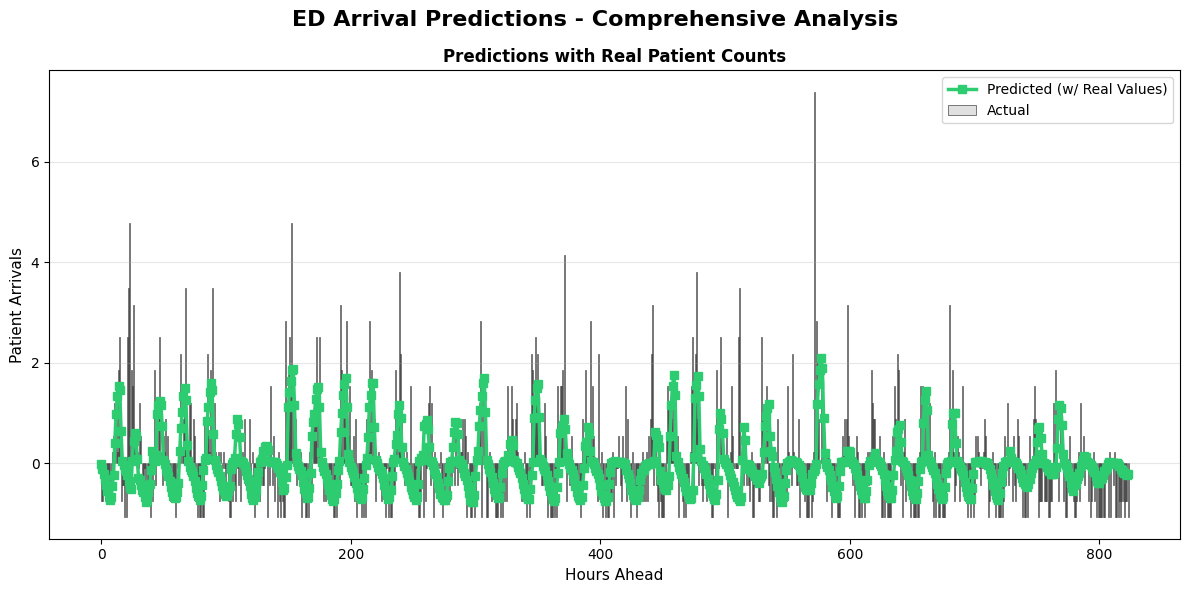

In [84]:
# =============================================================================
# VISUALIZATION
# =============================================================================

def visualize_predictions(y_true, y_pred_real, timestamps=None, save_path='predictions_comparison.png'):
    """
    Create comprehensive visualization of predictions vs actual values
    """
    print("\n[Visualization] Creating prediction comparison plots...")

    fig, ax = plt.subplots(figsize=(12, 6))
    fig.suptitle('ED Arrival Predictions - Comprehensive Analysis', fontsize=16, fontweight='bold')

    hours = np.arange(len(y_true))

    # Bar graph for actual values
    ax.bar(hours, y_true, label='Actual',
          color='lightgray', alpha=0.7,
          edgecolor='black', linewidth=0.5)

    # Line graph for predictions
    ax.plot(hours, y_pred_real, 's-',
            label='Predicted (w/ Real Values)',
            color='#2ecc71', linewidth=2.5, markersize=6)

    ax.set_xlabel('Hours Ahead', fontsize=11)
    ax.set_ylabel('Patient Arrivals', fontsize=11)
    ax.set_title('Predictions with Real Patient Counts',
                fontsize=12, fontweight='bold')

    ax.legend(loc='best')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved comprehensive visualization to {save_path}")
    plt.show()


visualize_predictions(
            y_true=y_test,
            y_pred_real=y_test_pred,
            save_path='predictions_comparison1.png'
        )


In [81]:
def autoregressive_forecast(model, initial_sequence, scaler_X, scaler_y,
                           n_steps, feature_cols,
                           ground_truth_current_counts=None):

    use_ground_truth = ground_truth_current_counts is not None
    mode = "with actual arrival_count values (teacher forcing)" if use_ground_truth else "with predicted values (autoregressive)"
    print(f"\nGenerating {n_steps}-step autoregressive forecast {mode}...")

    # Find the arrival_count feature index (the current hour's count used as input)
    arrival_count_idx = None
    for idx, col in enumerate(feature_cols):
        if col == 'arrival_count':
            arrival_count_idx = idx
            print(f"  Found arrival count feature at index {idx}: '{col}'")
            break

    if arrival_count_idx is None:
        print("  ERROR: arrival_count feature not found in features!")
        print("  You need to include arrival_count as a feature for Option B")
        return None

    predictions = []
    current_sequence = initial_sequence.copy()

    # Buffer to store recent arrival_count values for lag computation
    arrival_buffer = []

    for step in range(n_steps):
        # Predict arrival_count_next for T+step+1
        X_input = current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1])
        y_pred_scaled = model.predict(X_input, verbose=0)[0][0]
        y_pred = scaler_y.inverse_transform([[y_pred_scaled]])[0][0]
        predictions.append(y_pred)

        # Create new feature vector for next timestep
        new_features = current_sequence[-1].copy()

        # KEY STEP: Update arrival_count feature with the value at T+step+1
        if use_ground_truth and step < len(ground_truth_current_counts):
            # Use ACTUAL arrival_count at T+step+1
            current_count = ground_truth_current_counts[step]
            new_features[arrival_count_idx] = current_count
            arrival_buffer.append(current_count)
            if step < 3:
                actual = scaler_y.inverse_transform([[current_count]])[0][0]
                print(f"    Step {step}: Predicted {y_pred:.1f}, Using ACTUAL count={actual:.1f} as feature for T+{step+2}")
        else:
            # Use PREDICTED arrival_count_next (our prediction becomes the feature)
            new_features[arrival_count_idx] = y_pred_scaled
            arrival_buffer.append(y_pred_scaled)
            if step < 3:
                print(f"    Step {step}: Predicted {y_pred:.1f}, Using prediction as feature for T+{step+2}")

        # Slide window
        current_sequence = np.vstack([current_sequence[1:], new_features])

        if (step + 1) % 24 == 0:
            print(f"  Completed {step + 1}/{n_steps} predictions")

    return np.array(predictions)

# Autoregressive multi-step forecasting
print("\n" + "=" * 80)
print("AUTOREGRESSIVE MULTI-STEP FORECASTING")
print("=" * 80)

# Forecast next 24 hours
n_forecast_steps = 24

# Use the last sequence from test set as starting point
initial_sequence = X_test[0]  # [lookback, n_features]

# Option 1: Using REAL patient counts
if len(y_test) >= n_forecast_steps:
    ground_truth_scaled = y_test[:n_forecast_steps]

    ar_predictions_real = autoregressive_forecast(
        model=model,
        initial_sequence=initial_sequence,
        scaler_X=scaler_X,
        scaler_y=scaler_y,
        n_steps=n_forecast_steps,
        feature_cols=feature_cols,
        ground_truth_current_counts=ground_truth_scaled  # Use real values
    )

    # Evaluate with real values fed back
    y_true_original = scaler_y.inverse_transform(ground_truth_scaled.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_true_original, ar_predictions_real)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_original, ar_predictions_real)
    r2 = r2_score(y_true_original, ar_predictions_real)
    mape = np.mean(np.abs((y_true_original - ar_predictions_real) / (y_true_original + 1e-8))) * 100

    print(f"\nFirst {n_forecast_steps} hours predicted arrivals (with real values):")
    for i in range(min(n_forecast_steps, len(ar_predictions_real))):
        print(f"  Hour {i+1}: Predicted={ar_predictions_real[i]:.1f}, Actual={y_true_original[i]:.1f}")

    print(f"\n {n_forecast_steps}-Step Forecast WITH REAL VALUES:")
    print(f"  • RMSE: {rmse:.3f} arrivals")
    print(f"  • MAE: {mae:.3f} arrivals")
    print(f"  • R² Score: {r2:.4f}")
    print(f"  • MAPE: {mape:.2f}%")



print("\n" + "-" * 80)

# Option 2: Using PREDICTED patient counts (true autoregressive)
ar_predictions_pred = autoregressive_forecast(
    model=model,
    initial_sequence=initial_sequence,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    n_steps=n_forecast_steps,
    feature_cols=feature_cols,
    ground_truth_current_counts=None  # Use predictions only
)

print(f"\n Generated {n_forecast_steps}-hour forecast with predicted values")
print(f"\nFirst {n_forecast_steps} hours predicted arrivals (using only predictions):")
for i in range(min(n_forecast_steps, len(ar_predictions_pred))):
    print(f"  Hour {i+1}: {ar_predictions_pred[i]:.1f} patients")

# Evaluate pure autoregressive if we have ground truth
y_true_original = scaler_y.inverse_transform(ground_truth_scaled.reshape(-1, 1)).flatten()

mse = mean_squared_error(y_true_original, ar_predictions_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_original, ar_predictions_pred)
r2 = r2_score(y_true_original, ar_predictions_pred)
mape = np.mean(np.abs((y_true_original - ar_predictions_pred) / (y_true_original + 1e-8))) * 100

print(f"\n {n_forecast_steps}-Step Forecast WITH Predictions Only:")
print(f"  • RMSE: {rmse:.3f} arrivals")
print(f"  • MAE: {mae:.3f} arrivals")
print(f"  • R² Score: {r2:.4f}")
print(f"  • MAPE: {mape:.2f}%")


AUTOREGRESSIVE MULTI-STEP FORECASTING

Generating 24-step autoregressive forecast with actual arrival_count values (teacher forcing)...
  Found arrival count feature at index 0: 'arrival_count'
    Step 0: Predicted 4.2, Using ACTUAL count=2.0 as feature for T+2
    Step 1: Predicted 3.9, Using ACTUAL count=2.0 as feature for T+3
    Step 2: Predicted 3.6, Using ACTUAL count=3.0 as feature for T+4
  Completed 24/24 predictions

First 24 hours predicted arrivals (with real values):
  Hour 1: Predicted=4.2, Actual=2.0
  Hour 2: Predicted=3.9, Actual=2.0
  Hour 3: Predicted=3.6, Actual=3.0
  Hour 4: Predicted=3.3, Actual=3.0
  Hour 5: Predicted=3.0, Actual=3.0
  Hour 6: Predicted=2.6, Actual=3.0
  Hour 7: Predicted=2.2, Actual=2.0
  Hour 8: Predicted=2.1, Actual=3.0
  Hour 9: Predicted=2.4, Actual=2.0
  Hour 10: Predicted=3.1, Actual=5.0
  Hour 11: Predicted=4.3, Actual=6.0
  Hour 12: Predicted=5.5, Actual=8.0
  Hour 13: Predicted=6.3, Actual=7.0
  Hour 14: Predicted=6.0, Actual=5.0
  Ho


[Visualization] Creating prediction comparison plots...
Saved comprehensive visualization to predictions_comparison.png


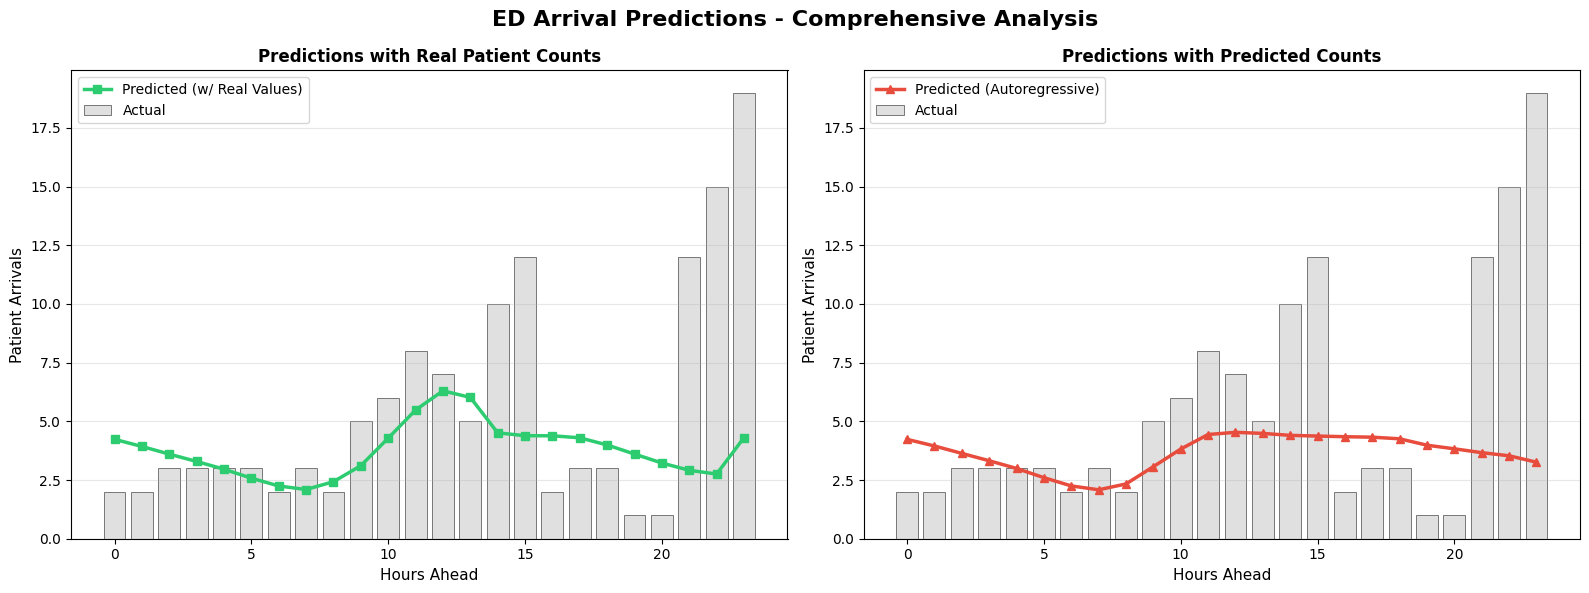

In [82]:
# =============================================================================
# VISUALIZATION
# =============================================================================

def visualize_predictions(y_true, y_pred_real, y_pred_auto, timestamps=None, save_path='predictions_comparison.png'):
    """
    Create comprehensive visualization of predictions vs actual values
    """
    print("\n[Visualization] Creating prediction comparison plots...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('ED Arrival Predictions - Comprehensive Analysis', fontsize=16, fontweight='bold')

    hours = np.arange(len(y_true))

    # 1. Main comparison plot - Teacher Forcing
    ax1 = axes[0]
    # Bar graph for actual values
    ax1.bar(hours, y_true, label='Actual', color='lightgray', alpha=0.7, edgecolor='black', linewidth=0.5)
    # Line graph for predictions
    ax1.plot(hours, y_pred_real, 's-', label='Predicted (w/ Real Values)', color='#2ecc71', linewidth=2.5, markersize=6)
    ax1.set_xlabel('Hours Ahead', fontsize=11)
    ax1.set_ylabel('Patient Arrivals', fontsize=11)
    ax1.set_title('Predictions with Real Patient Counts', fontsize=12, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3, axis='y')

    # 2. Main comparison plot - True Autoregressive
    ax2 = axes[1]
    # Bar graph for actual values
    ax2.bar(hours, y_true, label='Actual', color='lightgray', alpha=0.7, edgecolor='black', linewidth=0.5)
    # Line graph for predictions
    ax2.plot(hours, y_pred_auto, '^-', label='Predicted (Autoregressive)', color='#e74c3c', linewidth=2.5, markersize=6)
    ax2.set_xlabel('Hours Ahead', fontsize=11)
    ax2.set_ylabel('Patient Arrivals', fontsize=11)
    ax2.set_title('Predictions with Predicted Counts', fontsize=12, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved comprehensive visualization to {save_path}")
    plt.show()

visualize_predictions(
            y_true=y_true_original,
            y_pred_real=ar_predictions_real,
            y_pred_auto=ar_predictions_pred,
            save_path='predictions_comparison.png'
        )
